In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cellbayesassay as cba
import os.path
import re
import warnings
import attila_utils

## Data import

The next codeblock was used to remove 'nm' (not measurable?) values during the data cleaning process.

In [2]:
data_fpath = '../../resources/cell-based-assays/NIA_NOG_tox-CO25360-v2-cleaned.xlsx'
data = cba.get_data(data_fpath, sheet_name='Sheet1', TI_fpath='../../resources/cell-based-assays/test-items3a-v2.csv')
data

,Study,Experiment,Assay,Batch,Plate,TI,Name,conc,concentration,conc_log10,Activity
0,CO25360,Aβ toxicity (primary neurons),MTT,1,1,TI1,Valproic acid,c1,0.00005,-4.30103,50.30000
1,CO25360,Aβ toxicity (primary neurons),MTT,1,1,TI1,Valproic acid,c1,0.00005,-4.30103,54.50000
2,CO25360,Aβ toxicity (primary neurons),MTT,1,1,TI1,Valproic acid,c1,0.00005,-4.30103,51.50000
3,CO25360,Aβ toxicity (primary neurons),MTT,1,1,TI1,Valproic acid,c1,0.00005,-4.30103,51.10000
4,CO25360,Aβ toxicity (primary neurons),MTT,1,1,TI1,Valproic acid,c1,0.00005,-4.30103,48.60000
...,...,...,...,...,...,...,...,...,...,...,...
2851,CO25360,Neurite outgrowth (primary neurons),Σ neurite area,3,4,TI27,TUDCA + fixed HCQ,c3,0.00001,-5.00000,74.86002
2852,CO25360,Neurite outgrowth (primary neurons),Σ neurite area,3,4,TI27,TUDCA + fixed HCQ,c3,0.00001,-5.00000,82.78183
2853,CO25360,Neurite outgrowth (primary neurons),Σ neurite area,3,4,TI27,TUDCA + fixed HCQ,c3,0.00001,-5.00000,63.04148
2854,CO25360,Neurite outgrowth (primary neurons),Σ neurite area,3,4,TI27,TUDCA + fixed HCQ,c3,0.00001,-5.00000,78.94833


## Check data

In [3]:
check_data = True
if check_data:
    testdf = cba.fit_multiple_units(data, unit_list=None, do_fit=False, do_print=False)
    print(testdf)

                                                                   study  \
CO25360 Aβ toxicity (primary neurons)       MTT            TI1   CO25360   
                                                           TI10  CO25360   
                                                           TI11  CO25360   
                                                           TI12  CO25360   
                                                           TI13  CO25360   
...                                                                  ...   
        Neurite outgrowth (primary neurons) Σ neurite area TI5   CO25360   
                                                           TI6   CO25360   
                                                           TI7   CO25360   
                                                           TI8   CO25360   
                                                           TI9   CO25360   

                                                                                       

## Fitting model

In [4]:
maindir = '../../results/2024-05-09-cell-bayes/'

if not os.path.exists(maindir + 'idatas/fpaths.csv'):
    idatadf = cba.fit_multiple_units(data, unit_list=None, accept_multi_batches=True)
    idatas = idatadf.idata
    fpathdf = cba.idatas_to_netcdf(idatas.dropna(), subdir='idatas/', maindir=maindir)
    print('idatas written to netcdf')
else:
    idatas = cba.idatas_from_netcdf(subdir='idatas/', maindir=maindir)
    print('idatas read from netcdf')

idatas = cba.sort_index_TI(idatas)
idatas

CO25360 Aβ toxicity (primary neurons) MTT TI1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


CO25360 Aβ toxicity (primary neurons) MTT TI11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 598 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 527 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI18


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


CO25360 Aβ toxicity (primary neurons) MTT TI22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


CO25360 Aβ toxicity (primary neurons) MTT TI23


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI24


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI25


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


CO25360 Aβ toxicity (primary neurons) MTT TI7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


CO25360 Aβ toxicity (primary neurons) MTT TI8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Aβ toxicity (primary neurons) MTT TI9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


CO25360 Neurite outgrowth (primary neurons) branch points TI1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


CO25360 Neurite outgrowth (primary neurons) branch points TI10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


CO25360 Neurite outgrowth (primary neurons) branch points TI12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


CO25360 Neurite outgrowth (primary neurons) branch points TI13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 444 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


CO25360 Neurite outgrowth (primary neurons) branch points TI15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 186 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


CO25360 Neurite outgrowth (primary neurons) branch points TI18


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI23


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI24


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI25


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) branch points TI27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


CO25360 Neurite outgrowth (primary neurons) branch points TI3


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


CO25360 Neurite outgrowth (primary neurons) branch points TI4


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


CO25360 Neurite outgrowth (primary neurons) branch points TI5


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


CO25360 Neurite outgrowth (primary neurons) branch points TI6


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


CO25360 Neurite outgrowth (primary neurons) branch points TI7


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


CO25360 Neurite outgrowth (primary neurons) branch points TI8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


CO25360 Neurite outgrowth (primary neurons) branch points TI9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


CO25360 Neurite outgrowth (primary neurons) longest neurite TI1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 539 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 295 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI18


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI23


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI24


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI25


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


CO25360 Neurite outgrowth (primary neurons) longest neurite TI3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI4


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI5


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


CO25360 Neurite outgrowth (primary neurons) longest neurite TI6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI7


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


CO25360 Neurite outgrowth (primary neurons) longest neurite TI8


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


CO25360 Neurite outgrowth (primary neurons) longest neurite TI9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2779 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3605 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI18


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distrib

CO25360 Neurite outgrowth (primary neurons) neurogenesis TI23


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI24


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI25


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI6


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


CO25360 Neurite outgrowth (primary neurons) neurogenesis TI9


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 364 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 435 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI18


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI23


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI24


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI25


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI3


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI4


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI5


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distrib

CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI7


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


CO25360 Neurite outgrowth (primary neurons) Σ neurite area TI9


/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pymc/model/core.py:1316: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ, y_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


idatas written to netcdf


study    experiment                           assay           TI  
CO25360  Aβ toxicity (primary neurons)        MTT             TI1     (posterior, log_likelihood, sample_stats, obse...
                                                              TI2     (posterior, log_likelihood, sample_stats, obse...
                                                              TI3     (posterior, log_likelihood, sample_stats, obse...
                                                              TI4     (posterior, log_likelihood, sample_stats, obse...
                                                              TI5     (posterior, log_likelihood, sample_stats, obse...
                                                                                            ...                        
         Neurite outgrowth (primary neurons)  Σ neurite area  TI23    (posterior, log_likelihood, sample_stats, obse...
                                                              TI24    (posterior, log_likelih

## Fitted curves: posterior sample

In [20]:
plot_sampled_curves = True
fpath_suffix = '' if plot_sampled_curves else '-no-curves'

def assay_plotter(experiment, assay, plot_sampled_curves=plot_sampled_curves, compound_name_title=False):
    unit_list = idatas.loc(axis=0)[:, experiment, assay, :].index.to_numpy()
    fig, ax = cba.plot_multiple_units(unit_list, data, idatas, plot_sampled_curves=plot_sampled_curves, compound_name_title=compound_name_title)
    fig.suptitle(experiment + '\n' + assay)
    return((fig, ax))

for e, a in data[['Experiment', 'Assay']].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1).unique():
    print(e, a)

Aβ toxicity (primary neurons) MTT
Neurite outgrowth (primary neurons) branch points
Neurite outgrowth (primary neurons) longest neurite
Neurite outgrowth (primary neurons) neurogenesis
Neurite outgrowth (primary neurons) Σ neurite area


/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesass

['named-figure/fitted-curves-Aβ-toxicity-primary-neurons-MTT.png',
 'named-figure/fitted-curves-Aβ-toxicity-primary-neurons-MTT.pdf']

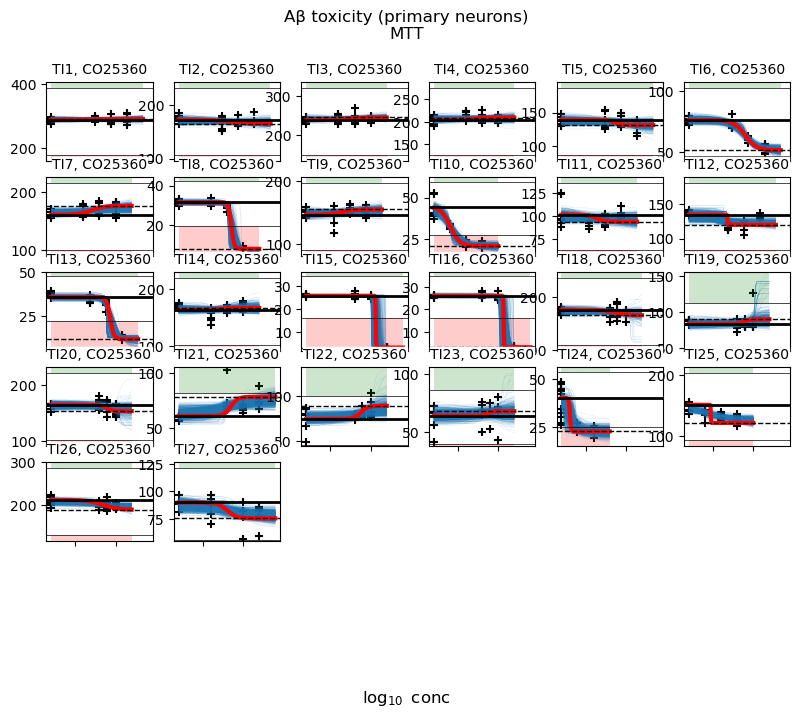

In [21]:
experiment = 'Aβ toxicity (primary neurons)'
assay = 'MTT'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesass

['named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-branch-points.png',
 'named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-branch-points.pdf']

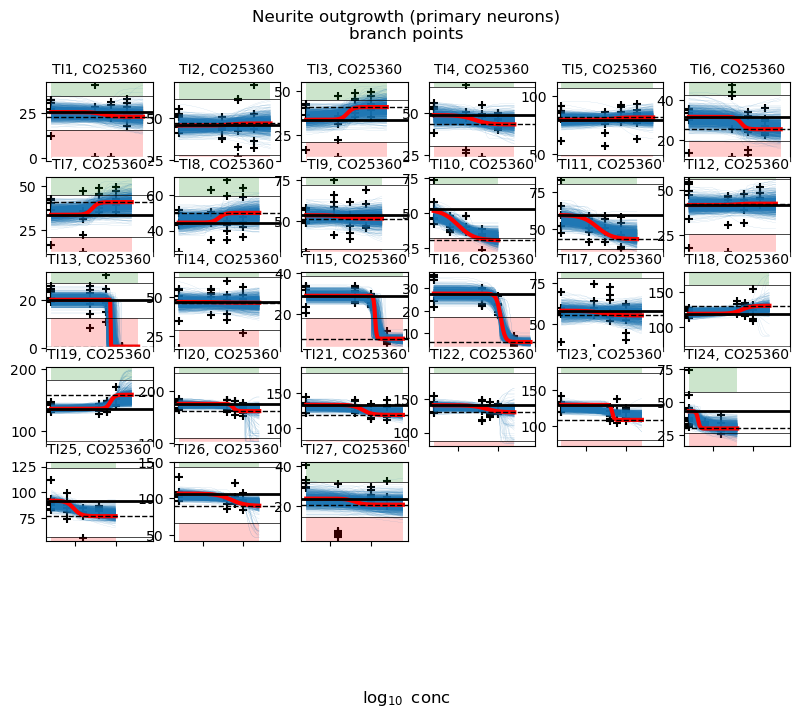

In [22]:
experiment = 'Neurite outgrowth (primary neurons)'
assay = 'branch points'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:267: RuntimeWarning: overflow encountered in exp
  y_sigmoid_1_mean = y_1_mean + (y_0_mean - y_1_mean) / (1 + np.exp(k_mean * (xx - EC_50_mean)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/

['named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-longest-neurite.png',
 'named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-longest-neurite.pdf']

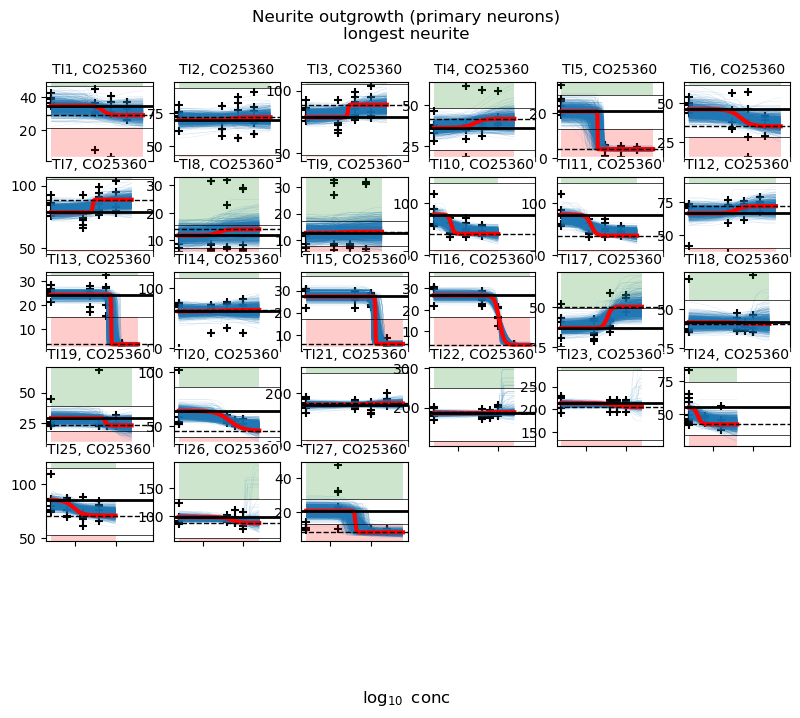

In [23]:
experiment = 'Neurite outgrowth (primary neurons)'
assay = 'longest neurite'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesass

['named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-neurogenesis.png',
 'named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-neurogenesis.pdf']

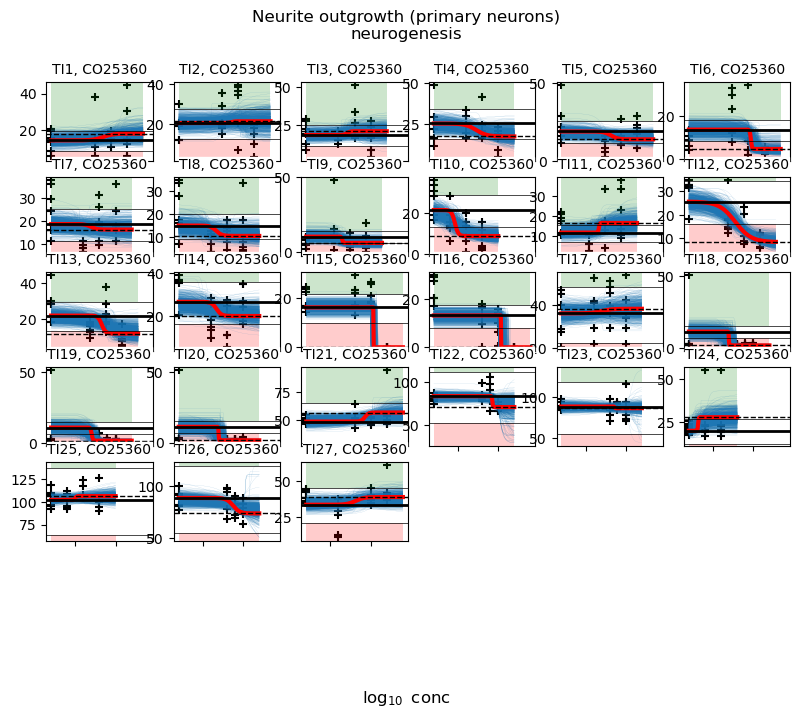

In [24]:
experiment = 'Neurite outgrowth (primary neurons)'
assay = 'neurogenesis'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:261: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/Users/jonesa7/CTNS/notebooks/src/cellbayesass

['named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-Σ-neurite-area.png',
 'named-figure/fitted-curves-Neurite-outgrowth-primary-neurons-Σ-neurite-area.pdf']

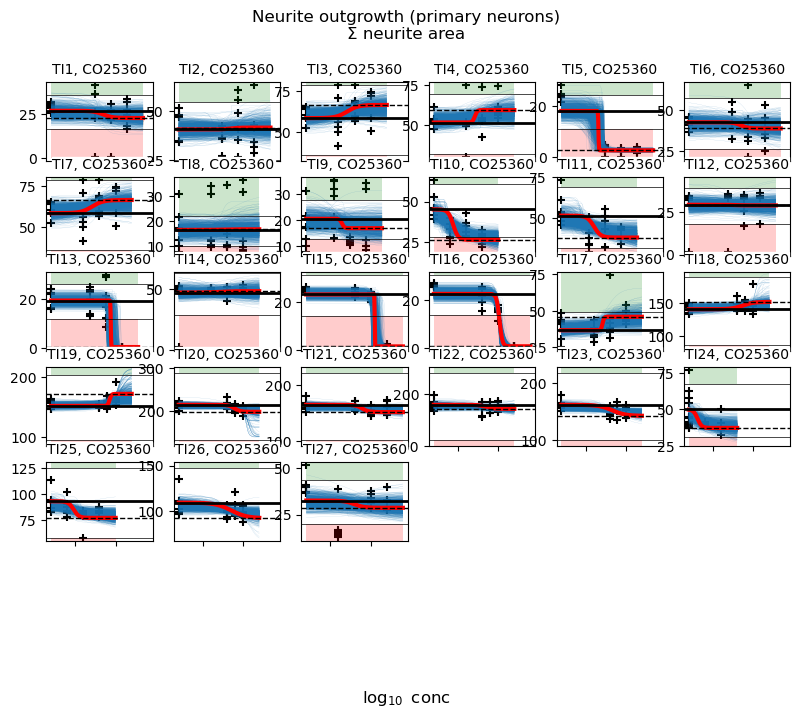

In [25]:
experiment = 'Neurite outgrowth (primary neurons)'
assay = 'Σ neurite area'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

## MCMC diagnostics

In [26]:
cba.get_diagnostics_series(idatas, az.ess)

In [27]:
cba.get_diagnostics_series(idatas, az.rhat, vmax=1.1)

In [28]:
df = cba.get_diagnostics_series(idatas, az.mcse, return_df=True).drop('k', level='parameter', axis=0)
df.style.format(precision=3).background_gradient(axis=None, vmin=df.min().min(), vmax=df.max().max(), cmap='hot')

['named-figure/ess.png', 'named-figure/ess.pdf']

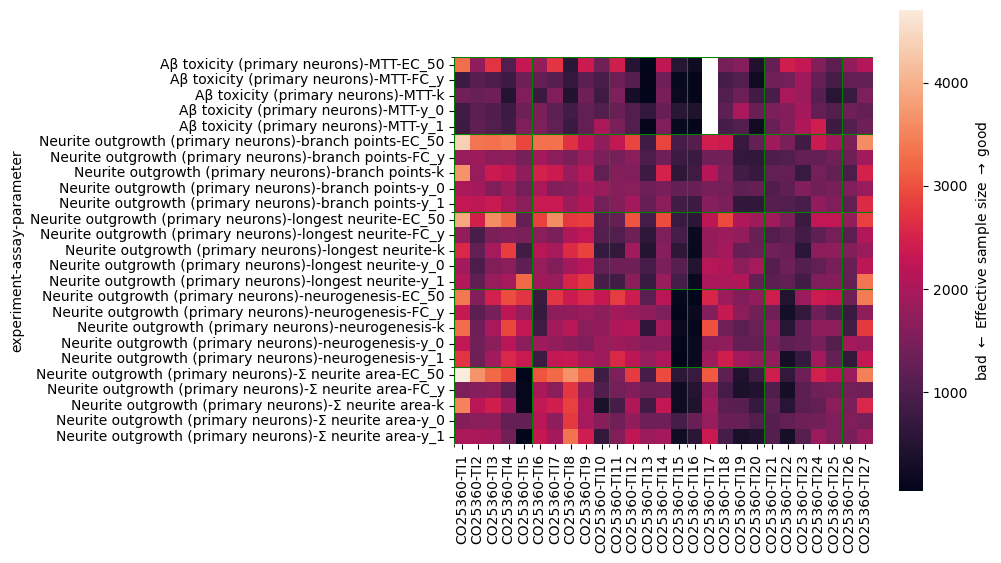

In [29]:
g = cba.diagnostics_series_heatmap(idatas, az.ess, yticklabels=True)
attila_utils.savefig(g.figure, 'ess')

['named-figure/rhat.png', 'named-figure/rhat.pdf']

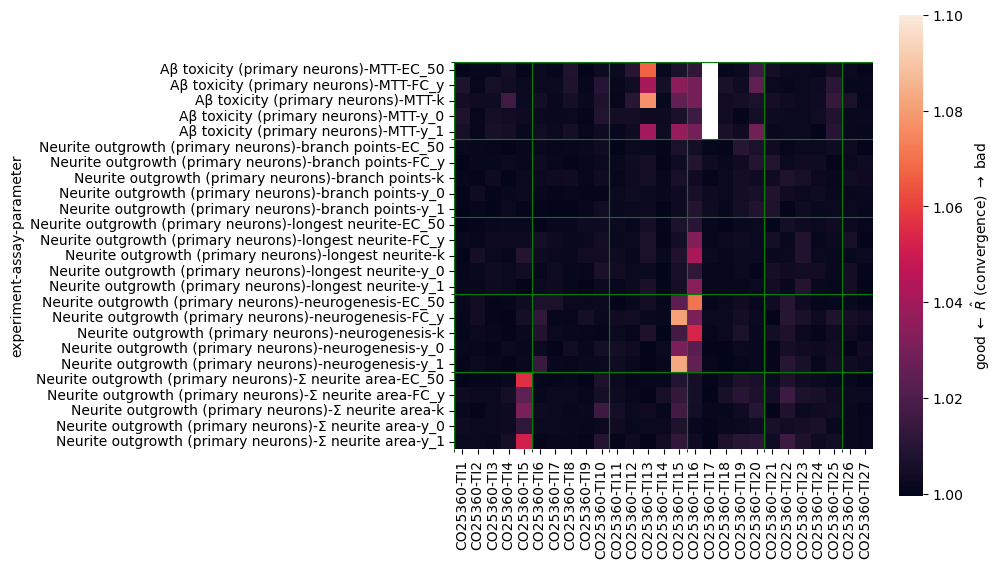

In [30]:
g = cba.diagnostics_series_heatmap(idatas, az.rhat, yticklabels=True, vmax=1.1)
attila_utils.savefig(g.figure, 'rhat')

['named-figure/mcse.png', 'named-figure/mcse.pdf']

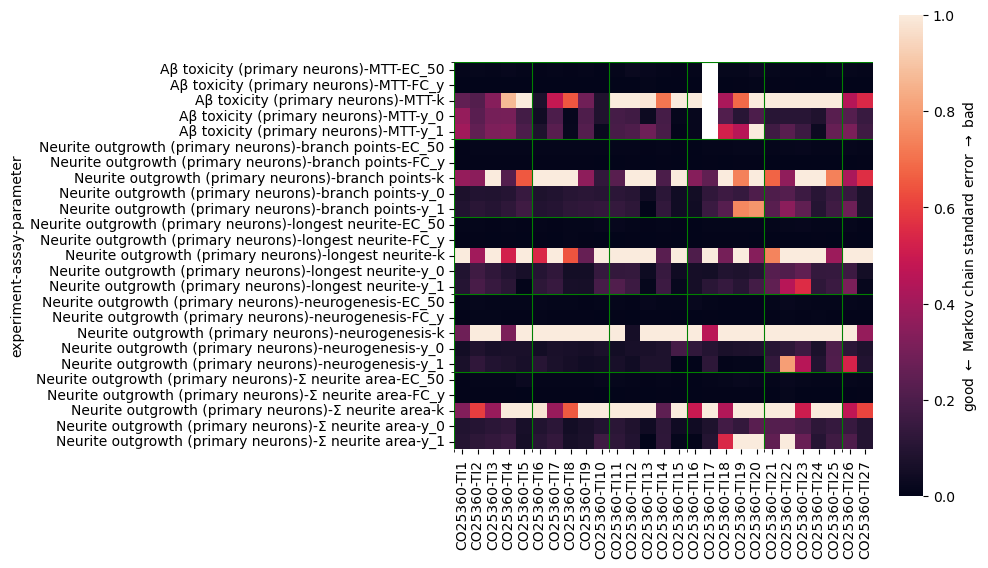

In [31]:
g = cba.diagnostics_series_heatmap(idatas, az.mcse, yticklabels=True, vmax=1)
attila_utils.savefig(g.figure, 'mcse')

In [32]:
%connect_info

{
  "shell_port": 59351,
  "iopub_port": 59352,
  "stdin_port": 59353,
  "control_port": 59355,
  "hb_port": 59354,
  "ip": "127.0.0.1",
  "key": "4c9efef8-7f231f08514e9a6166c6598a",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-05-09-cell-bayes/2024-05-09-cell-bayes.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-a8cad2e0-e849-4963-bef1-b63968e1e0b9.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
